# Import libraries and files

In [ ]:
import pandas as pd
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go


In [ ]:
# Get the spreadsheet ID and name
sheet_id ="1fZymg9_EA3XFq-H4GTKF3PPLsj7gudvW2i43SUHhiuc"
sheet_name ="1613676130"

# Construct the URL to the CSV export of the spreadsheet
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_name}"

# Read the CSV data into a Pandas DataFrame
songs_df = pd.read_csv(url,
                       index_col=['name','artist'] )

# Data cleaning

The columns "type," "key," "duration_ms," and "time_signature" are not contributing to our analysis or model's performance, it's efficient to drop them. It makes the data cleaner and more manageable, which often leads to better insights and reduces computational overhead.

In [ ]:
# Drop the 'id' and 'html'
to_drop = ['id', 'html']
songs_df = songs_df.drop(columns=to_drop)

In [ ]:
#'type' column is nan - drop with other not useful columns
songs_df = songs_df.drop(["type", "key", "duration_ms", "time_signature"], axis = 1)

In [ ]:
# Replace commas with periods in your DataFrame
songs_df = songs_df.replace(',', '.', regex=True)

# Convert columns to numeric, coercing errors to NaN
songs_df = songs_df.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
songs_df.dropna(inplace=True)

In [ ]:
songs_df = songs_df.drop(columns=['Unnamed: 0'])

In [ ]:
songs_df

,,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
name,artist,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,658.0,259.00,-13.141,0,705.0,694.0,0.000059,975.0,306.0,110.376
Saudade De Bahia,Antônio Carlos Jobim,742.0,399.00,-12.646,1,346.0,217.0,0.000002,107.0,693.0,125.039
"Canta Canta, Minha Gente",Martinho Da Vila,851.0,0.73,-11.048,1,347.0,453.0,0.000063,124.0,905.0,93.698
Mulher Eu Sei,Chico César,705.0,502.00,-18.115,1,471.0,879.0,0.000041,386.0,524.0,106.802
Rosa Morena,Kurt Elling,651.0,119.00,-19.807,1,38.0,916.0,343.000000,104.0,402.0,120.941
...,...,...,...,...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",Pyotr Ilyich Tchaikovsky,202.0,694.00,-23.390,1,473.0,917.0,715.000000,832.0,655.0,87.906
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",Tristan Murail,188.0,101.00,-21.873,1,442.0,855.0,426.000000,694.0,355.0,83.134
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",Arnold Schoenberg,596.0,93.00,-42.959,1,434.0,951.0,969.000000,772.0,344.0,71.573


# Scalers - changing the range, but not the distribution

The minmax scales all your features to a given range, usually [0, 1], which keeps the relative relationships between the values intact. Since the data includes a lot of different metrics like danceability, energy, loudness, etc., normalizing these helps level the playing field for clustering. It prevents features with larger scales from dominating the clustering process.

In [ ]:
# Create a MinMaxScaler object
scaler = MinMaxScaler().set_output(transform="pandas")
# Scale the songs_df DataFrame
songs_scaled_min_max = scaler.fit_transform(songs_df)

In [ ]:
songs_scaled_min_max

,,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
name,artist,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.661972,0.259259,0.529571,0.0,0.705706,0.695391,5.875876e-08,0.975976,0.306613,0.515800
Saudade De Bahia,Antônio Carlos Jobim,0.746479,0.399399,0.529861,1.0,0.346346,0.217435,1.881882e-09,0.107107,0.694389,0.584322
"Canta Canta, Minha Gente",Martinho Da Vila,0.856137,0.000731,0.530800,1.0,0.347347,0.453908,6.346346e-08,0.124124,0.906814,0.437862
Mulher Eu Sei,Chico César,0.709256,0.502503,0.526650,1.0,0.471471,0.880762,4.054054e-08,0.386386,0.525050,0.499098
Rosa Morena,Kurt Elling,0.654930,0.119119,0.525656,1.0,0.038038,0.917836,3.433433e-01,0.104104,0.402806,0.565171
...,...,...,...,...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",Pyotr Ilyich Tchaikovsky,0.203219,0.694695,0.523553,1.0,0.473473,0.918838,7.157157e-01,0.832833,0.656313,0.410795
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",Tristan Murail,0.189135,0.101101,0.524443,1.0,0.442442,0.856713,4.264264e-01,0.694695,0.355711,0.388495
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",Arnold Schoenberg,0.599598,0.093093,0.512062,1.0,0.434434,0.952906,9.699700e-01,0.772773,0.344689,0.334469


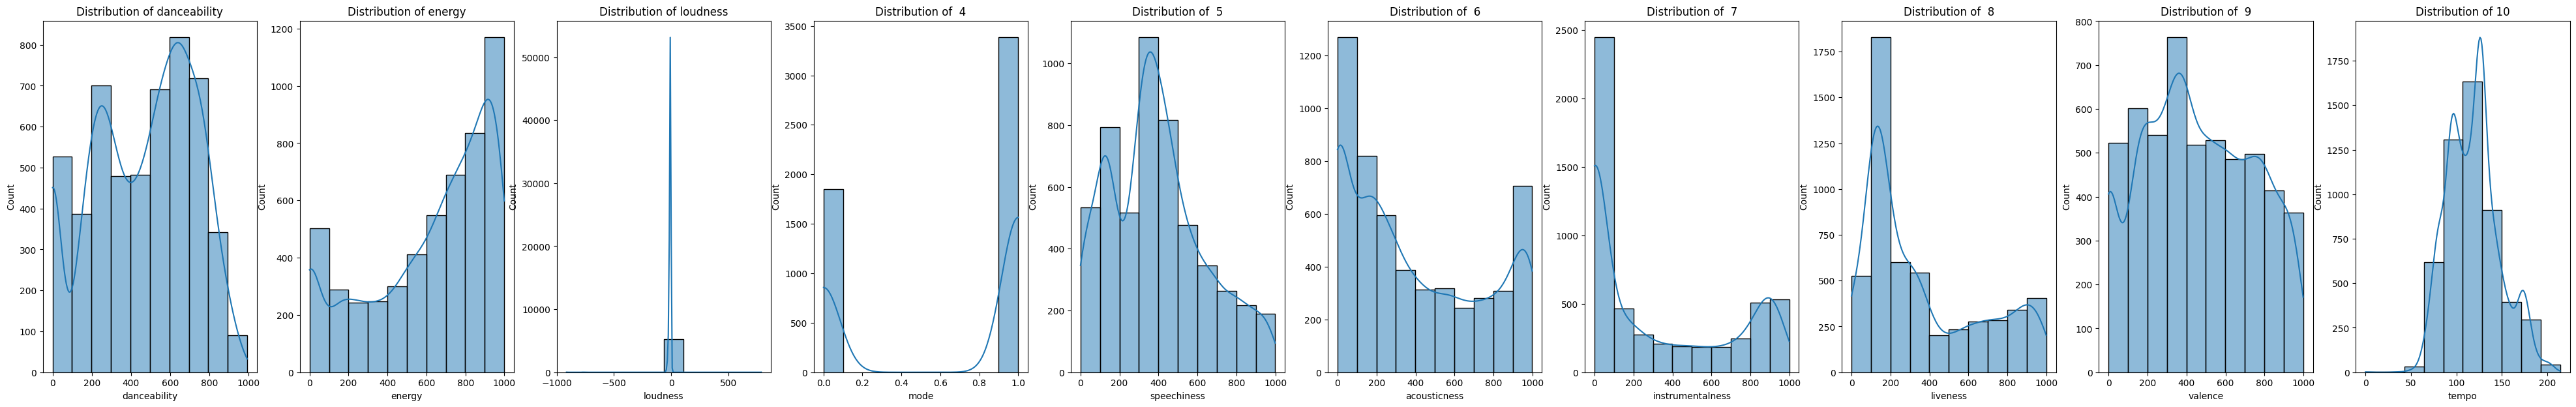

In [ ]:
# Stating that we want 10 plots
fig, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10] = plt.subplots(nrows=1, ncols=10)
fig.set_size_inches(50, 7)

# Plotting the 10 plots
sns.histplot(songs_df.iloc[:, 0], bins=10, kde=True, ax=ax1)
sns.histplot(songs_df.iloc[:, 1], bins=10, kde=True, ax=ax2)
sns.histplot(songs_df.iloc[:, 2], bins=10, kde=True, ax=ax3)
sns.histplot(songs_df.iloc[:, 3], bins=10, kde=True, ax=ax4)
sns.histplot(songs_df.iloc[:, 4], bins=10, kde=True, ax=ax5)
sns.histplot(songs_df.iloc[:, 5], bins=10, kde=True, ax=ax6)
sns.histplot(songs_df.iloc[:, 6], bins=10, kde=True, ax=ax7)
sns.histplot(songs_df.iloc[:, 7], bins=10, kde=True, ax=ax8)
sns.histplot(songs_df.iloc[:, 8], bins=10, kde=True, ax=ax9)
sns.histplot(songs_df.iloc[:, 9], bins=10, kde=True, ax=ax10)

# Adding titles to the plots
ax1.set_title('Distribution of danceability')
ax2.set_title('Distribution of energy')
ax3.set_title('Distribution of loudness')
ax4.set_title('Distribution of  4')
ax5.set_title('Distribution of  5')
ax6.set_title('Distribution of  6')
ax7.set_title('Distribution of  7')
ax8.set_title('Distribution of  8')
ax9.set_title('Distribution of  9')
ax10.set_title('Distribution of 10')

# Displaying the plots
plt.show()

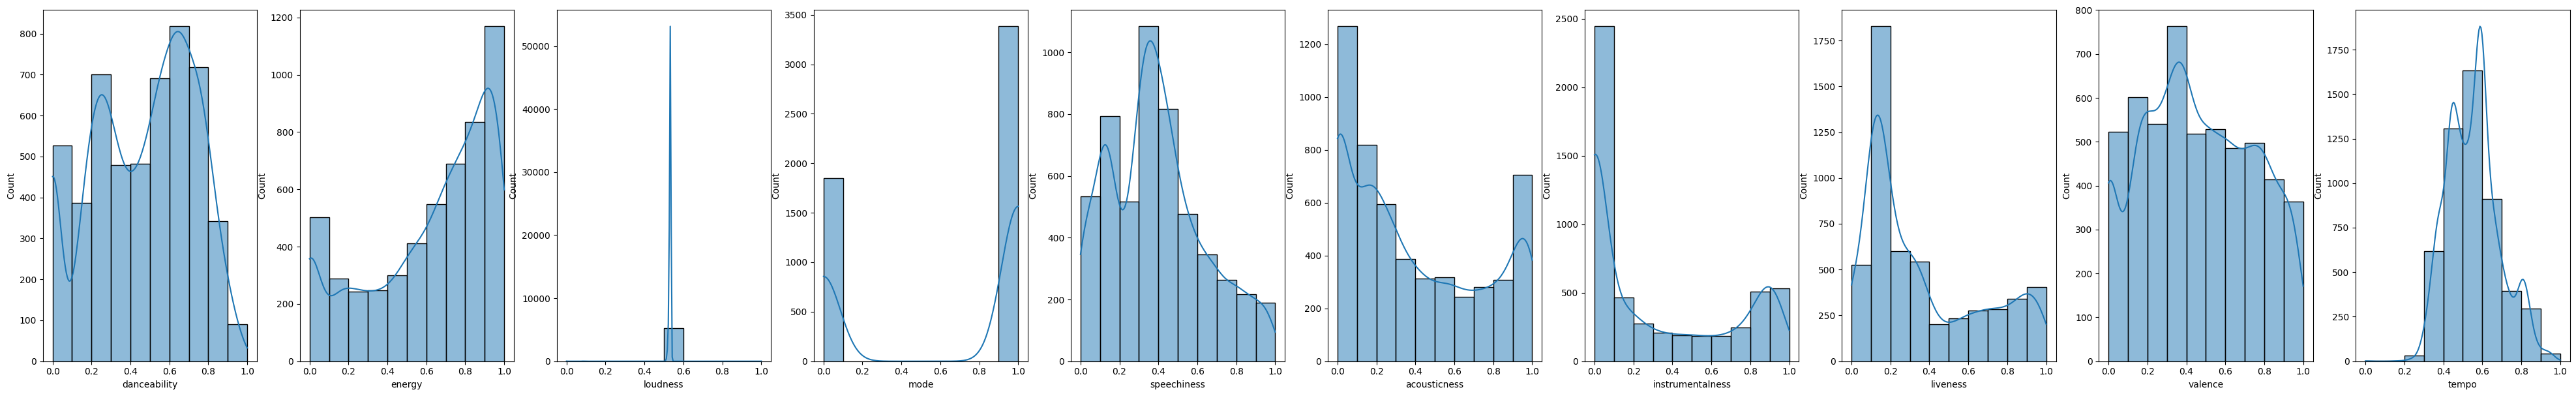

In [ ]:
# Stating that we want 10 plots
fig, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10] = plt.subplots(nrows=1, ncols=10)
fig.set_size_inches(50, 7)

# Plotting the 10 plots
sns.histplot(songs_scaled_min_max.iloc[:,0], bins=10, kde=True, ax=ax1);
sns.histplot(songs_scaled_min_max.iloc[:,1], bins=10, kde=True, ax=ax2);
sns.histplot(songs_scaled_min_max.iloc[:,2], bins=10, kde=True, ax=ax3);
sns.histplot(songs_scaled_min_max.iloc[:,3], bins=10, kde=True, ax=ax4);
sns.histplot(songs_scaled_min_max.iloc[:,4], bins=10, kde=True, ax=ax5);
sns.histplot(songs_scaled_min_max.iloc[:,5], bins=10, kde=True, ax=ax6);
sns.histplot(songs_scaled_min_max.iloc[:,6], bins=10, kde=True, ax=ax7);
sns.histplot(songs_scaled_min_max.iloc[:,7], bins=10, kde=True, ax=ax8);
sns.histplot(songs_scaled_min_max.iloc[:,8], bins=10, kde=True, ax=ax9);
sns.histplot(songs_scaled_min_max.iloc[:,9], bins=10, kde=True, ax=ax10);

# Adding titles to the plots
# ax1.set_title('Distribution of danceability without scaling')
# ax2.set_title('Distribution of danceability with MinMax scaling')

plt.show()

# Estimate the number of clusters (k)

# Inertia and the elbow method

In [ ]:
# Decide on a random_state to use
seed = 123

# Set the maximum number of clusters to try
max_k = 30

# Create an empty list to store the inertia scores
inertia_list = []

# Iterate over the range of cluster numbers
for i in range(1, max_k + 1):

    # Create a KMeans object with the specified number of clusters
    myKMeans = KMeans(n_clusters = i,
                      n_init = "auto",
                      random_state = seed)

    # Fit the KMeans model to the scaled data
    myKMeans.fit(songs_scaled_min_max)

    # Append the inertia score to the list
    inertia_list.append(myKMeans.inertia_)

In [ ]:
inertia_list

[4638.655483427334,
 3440.1494655201122,
 3017.620753227087,
 2759.7102255061404,
 2582.4918493616638,
 2460.05553166438,
 2369.580858572174,
 2187.5915490610064,
 2201.6148934593734,
 1977.5018014441234,
 1895.3298946298726,
 1847.0636081283324,
 1804.917754268174,
 1748.3632113153246,
 1699.8750764691174,
 1647.8019123839433,
 1606.9228259975287,
 1599.8811226542193,
 1577.7696774301671,
 1522.28586758977,
 1498.2902838756029,
 1469.0359420906477,
 1442.5415328419804,
 1424.7772028041552,
 1387.9404415101862,
 1367.8484459384333,
 1349.4877585195636,
 1324.0556450566141,
 1321.9737646339795,
 1300.616474947535]

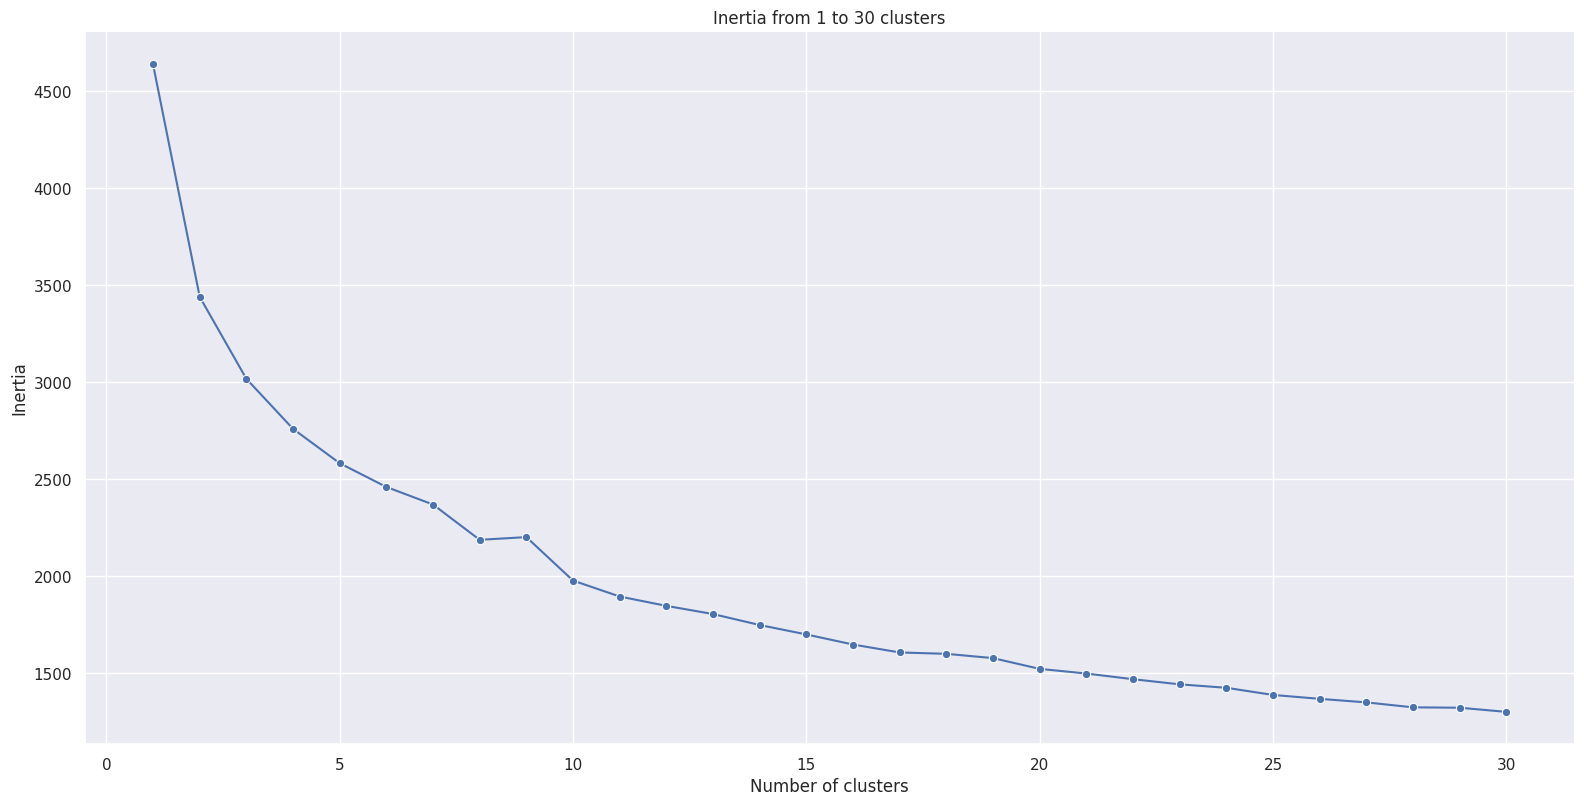

In [ ]:
# Set the Seaborn theme to darkgrid
sns.set_theme(style='darkgrid')

(
# Create a line plot of the inertia scores
sns.relplot(y = inertia_list,
            x = range(1, max_k + 1),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2)
# Set the title of the plot
.set(title=f"Inertia from 1 to {max_k} clusters")
# Set the axis labels
.set_axis_labels("Number of clusters", "Inertia")
);

The slope of the graph is decreasing from around the 10th to the 40th cluster

# The silhouette score

In [ ]:
# Set the maximum number of clusters to try
max_k = 30
# Create an empty list to store the silhouette scores
sil_scores = []


for j in range(2, max_k):

    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters = j,
                    n_init = "auto",
                    random_state = seed)

    # Fit the KMeans model to the scaled data
    kmeans.fit(songs_scaled_min_max)

    # Get the cluster labels
    labels = kmeans.labels_

    # Calculate the silhouette score
    score = silhouette_score(songs_scaled_min_max, labels)

    # Append the silhouette score to the list
    sil_scores.append(score)

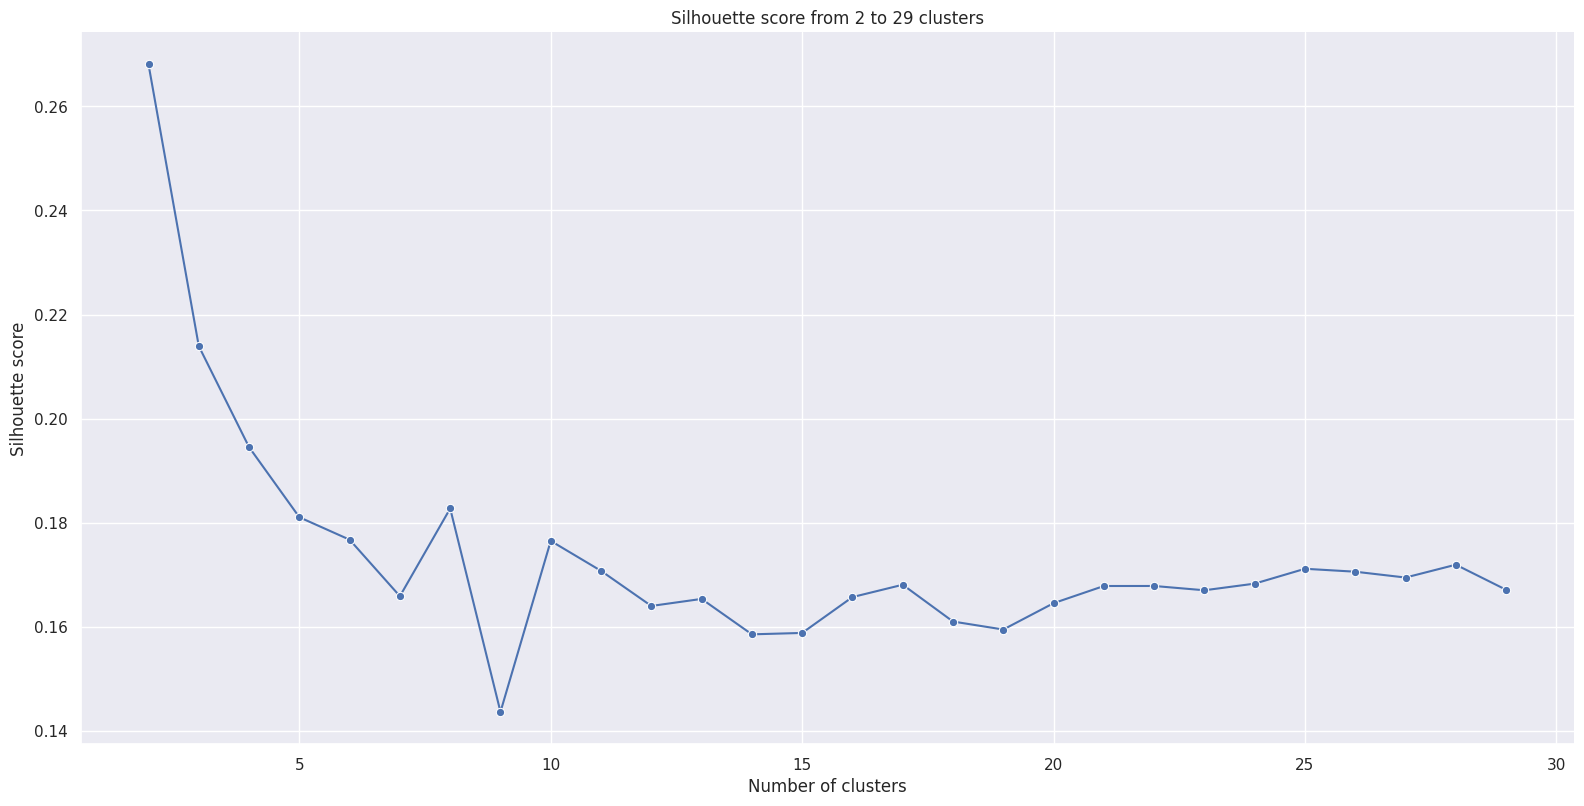

In [ ]:
(
sns.relplot(y = sil_scores,
            x = range(2, max_k),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2)
.set(title=f"Silhouette score from 2 to {max_k - 1} clusters")
.set_axis_labels("Number of clusters", "Silhouette score")
);

The Silhouette Score ranges generally from -1 to 1, indicating how well each data point fits within its cluster. A score close to 1 means the data points are well-clustered, while scores near 0 suggest overlapping clusters, and negative values indicate misclassified points. Ideally, a high Silhouette Score (close to 1) is the best, reflecting clear and distinct clusters.

# Retrieve genres for each song using Spotify's API:

In [ ]:
! pip install spotipy

In [ ]:
# Reset index to make 'artist' a regular column
songs_df.reset_index(inplace=True)


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import time




# Function to get genres for a given artist using Spotify API
def get_genres(artist_name):
    try:
        # Search for the artist on Spotify
        results = spotify.search(q=f'artist:{artist_name}', type='artist', limit=1)
        artist_info = results['artists']['items'][0]  # Get first matching artist
        genres = artist_info.get('genres', [])
        return genres
    except (IndexError, KeyError):
        print(f"Genres not found for artist '{artist_name}'")
        return []

# Apply the genre retrieval function with a delay to avoid rate limits
songs_df['genres'] = songs_df['artist'].apply(get_genres)
time.sleep(0.1)  # 100ms delay to avoid hitting rate limits for large datasets

# Save the updated DataFrame with genres added to a new CSV file
output_path = 'updated_5000_songs_with_genres.csv'
songs_df.to_csv(output_path, index=False)
print(f"Updated file saved as '{output_path}'")


Genres not found for artist 'Pete Krebs & The Kung Pao Chi'
Genres not found for artist 'Craig James Fox'
Genres not found for artist 'College & Electric Youth'
Genres not found for artist 'Albert Pla & Pascal Comelade'
Genres not found for artist 'Andy Stringer'
Genres not found for artist 'Andy Stringer'
Genres not found for artist 'Andy Stringer'
Genres not found for artist 'Andy Stringer'
Genres not found for artist 'Andy Stringer'
Genres not found for artist 'Martin Solveig Vs. GTA'
Genres not found for artist 'Hardwell & Dyro feat. Bright Lights'
Genres not found for artist 'Felix Da Housecat feat. will.i.am'
Genres not found for artist 'Chuckie feat. Gregor Salto'
Genres not found for artist 'Daddy's Groove'
Genres not found for artist 'J Majik & Wickaman feat. Kate Loveridge'
Genres not found for artist 'T1419'
Genres not found for artist 'T1419'
Genres not found for artist 'Stefan Raab feat. Shaggy'
Genres not found for artist 'Uwu Lena'
Updated file saved as 'updated_5000_son

In [ ]:
import pandas as pd

# Load the updated file
updated_file_path = 'updated_5000_songs_with_genres.csv'
updated_df = pd.read_csv(updated_file_path)

# Display the first few rows
print(updated_df.head())


                                                name                artist  \
0                        Se Eu Quiser Falar Com Deus          Gilberto Gil   
1                                   Saudade De Bahia  Antônio Carlos Jobim   
2  Canta Canta, Minha Gente                      ...      Martinho Da Vila   
3                                      Mulher Eu Sei           Chico César   
4                                        Rosa Morena           Kurt Elling   

   danceability  energy  loudness  mode  speechiness  acousticness  \
0         658.0  259.00   -13.141     0        705.0         694.0   
1         742.0  399.00   -12.646     1        346.0         217.0   
2         851.0    0.73   -11.048     1        347.0         453.0   
3         705.0  502.00   -18.115     1        471.0         879.0   
4         651.0  119.00   -19.807     1         38.0         916.0   

   instrumentalness  liveness  valence    tempo  \
0          0.000059     975.0    306.0  110.376   
1       

In [ ]:
import pandas as pd

# Load the updated file
updated_file_path = 'updated_5000_songs_with_genres.csv'
updated_df = pd.read_csv(updated_file_path)

# Ensure 'genres' is interpreted as a list, if necessary
updated_df['genres'] = updated_df['genres'].apply(eval)  # Only if 'genres' is a string representation of a list

# Explode the 'genres' column to create a row for each genre
expanded_df = updated_df.explode('genres')

# Group by 'genres' and count the number of songs per genre
genre_counts = expanded_df['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'song_count']

# Display the genre counts
print(genre_counts.head(30))


                        genre  song_count
0                 death metal         547
1                         pop         513
2          brutal death metal         450
3                         edm         365
4                       metal         363
5                   pop dance         332
6                  deathgrind         304
7                   dance pop         289
8       technical death metal         263
9                   reggaeton         251
10                black metal         245
11              urbano latino         227
12                  classical         226
13                       rock         225
14              electro house         225
15                  soft rock         198
16               thrash metal         193
17                mellow gold         192
18               classic rock         191
19  progressive electro house         185
20                       jazz         171
21                 german pop         162
22                trap latino     

# The cluster means

# Column averages

In [ ]:
# Initialise the model
my_kmeans = KMeans(n_clusters = 25, # you always choose the number of k here
                   random_state = 123)

# Fit the model to the data
my_kmeans.fit(songs_scaled_min_max)

# Obtain the cluster output
clusters = my_kmeans.labels_

# Attach the cluster output to our original DataFrame
songs_scaled_min_max["cluster"] = clusters

In [ ]:
songs_scaled_min_max

,,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
name,artist,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.661972,0.259259,0.529571,0.0,0.705706,0.695391,5.875876e-08,0.975976,0.306613,0.515800,8
Saudade De Bahia,Antônio Carlos Jobim,0.746479,0.399399,0.529861,1.0,0.346346,0.217435,1.881882e-09,0.107107,0.694389,0.584322,20
"Canta Canta, Minha Gente",Martinho Da Vila,0.856137,0.000731,0.530800,1.0,0.347347,0.453908,6.346346e-08,0.124124,0.906814,0.437862,4
Mulher Eu Sei,Chico César,0.709256,0.502503,0.526650,1.0,0.471471,0.880762,4.054054e-08,0.386386,0.525050,0.499098,11
Rosa Morena,Kurt Elling,0.654930,0.119119,0.525656,1.0,0.038038,0.917836,3.433433e-01,0.104104,0.402806,0.565171,23
...,...,...,...,...,...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",Pyotr Ilyich Tchaikovsky,0.203219,0.694695,0.523553,1.0,0.473473,0.918838,7.157157e-01,0.832833,0.656313,0.410795,2
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",Tristan Murail,0.189135,0.101101,0.524443,1.0,0.442442,0.856713,4.264264e-01,0.694695,0.355711,0.388495,2
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",Arnold Schoenberg,0.599598,0.093093,0.512062,1.0,0.434434,0.952906,9.699700e-01,0.772773,0.344689,0.334469,2


In [ ]:
# to take a sample of x songs from each cluster

# select specific columns from labeled_songs DataFrame to create audio_sample DataFrame
audio_sample = songs_scaled_min_max[['cluster']]

# set the number of samples to select from each cluster
n = 5

# iterate over unique cluster labels in audio_sample DataFrame
for x in audio_sample['cluster'].unique():
    # select random samples from audio_sample where cluster equals current cluster label 'x'
    samples = audio_sample.query(f'cluster == {x}').sample(n=n)
    # print the selected samples
    print(samples)

                                                        cluster
name                                 artist                    
A Sky Full of Stars - Hardwell Remix Coldplay                 8
Blessed & Highly Favored - Live      The Clark Sisters        8
Karoliina Kaunis                     Maria Gasolina           8
DJ Got Us Fallin' In Love            Usher                    8
You Don't Know                       Eminem                   8
                                             cluster
name                               artist           
You Make Me                        Avicii          4
Pits of Utumno                     Morgoth         4
Butter (feat. Megan Thee Stallion) BTS             4
Qué Más Pues?                      J Balvin        4
Wake Me Up Before You Go-Go        Wham!           4
                                                                    cluster
name                                               artist                  
Code Red - 94 Remix          

Cluster 8

| Song                                   | Artist               | Genre                     |
|----------------------------------------|----------------------|---------------------------|
| A Sky Full of Stars - Hardwell Remix   | Coldplay             | Electronic/Dance          |
| Blessed & Highly Favored - Live        | The Clark Sisters    | Gospel                    |
| Karoliina Kaunis                       | Maria Gasolina       | Pop                       |
| DJ Got Us Fallin' In Love              | Usher                | R&B                       |
| You Don't Know                         | Eminem               | Hip-Hop/Rap               |


Cluster 6

| Cluster | Artist                      | Genre |
|---------|-----------------------------|-------|
| 6       | Deceased                    | Metal |
| 6       | Cannibal Corpse             | Metal |
| 6       | Altar                       | Metal |
| 6       | Brutal Truth                | Metal |
| 6       | J Majik & Wickaman feat. Kate Loveridge | Metal |


In [ ]:
songs_scaled_min_max.groupby(by="cluster").mean()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,,
0,0.282664,0.890833,0.532697,1.0,0.190641,0.120937,0.801264,0.190241,0.399821,0.562753
1,0.522891,0.484524,0.531196,0.0,0.389202,0.806339,0.084207,0.197902,0.428871,0.551820
2,0.424090,0.278477,0.529565,1.0,0.379472,0.832573,0.090581,0.147285,0.353984,0.514562
3,0.115736,0.777959,0.530548,1.0,0.495542,0.226452,0.076035,0.197033,0.480482,0.593348
4,0.676793,0.737611,0.532004,1.0,0.334316,0.199035,0.082868,0.192295,0.739541,0.550583
5,0.338647,0.345867,0.524065,1.0,0.420158,0.923537,0.855258,0.834261,0.385793,0.483584
6,0.319169,0.872168,0.532639,0.0,0.417151,0.112142,0.784138,0.346312,0.334653,0.571592
7,0.682925,0.692655,0.533088,1.0,0.376266,0.279773,0.076160,0.771678,0.721058,0.562887
8,0.644716,0.665651,0.532881,0.0,0.368972,0.410791,0.088099,0.814743,0.582601,0.548905


# 10 Cluster Approach

In [ ]:
# Initialise the model
my_kmeans = KMeans(n_clusters = 10, # you always choose the number of k here
                   random_state = 123)

# Fit the model to the data
my_kmeans.fit(songs_scaled_min_max)

# Obtain the cluster output
clusters = my_kmeans.labels_

# Attach the cluster output to our original DataFrame
songs_scaled_min_max["cluster"] = clusters

In [ ]:
songs_scaled_min_max

,,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
name,artist,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.661972,0.259259,0.529571,0.0,0.705706,0.695391,5.875876e-08,0.975976,0.306613,0.515800,7
Saudade De Bahia,Antônio Carlos Jobim,0.746479,0.399399,0.529861,1.0,0.346346,0.217435,1.881882e-09,0.107107,0.694389,0.584322,5
"Canta Canta, Minha Gente",Martinho Da Vila,0.856137,0.000731,0.530800,1.0,0.347347,0.453908,6.346346e-08,0.124124,0.906814,0.437862,6
Mulher Eu Sei,Chico César,0.709256,0.502503,0.526650,1.0,0.471471,0.880762,4.054054e-08,0.386386,0.525050,0.499098,9
Rosa Morena,Kurt Elling,0.654930,0.119119,0.525656,1.0,0.038038,0.917836,3.433433e-01,0.104104,0.402806,0.565171,5
...,...,...,...,...,...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",Pyotr Ilyich Tchaikovsky,0.203219,0.694695,0.523553,1.0,0.473473,0.918838,7.157157e-01,0.832833,0.656313,0.410795,7
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",Tristan Murail,0.189135,0.101101,0.524443,1.0,0.442442,0.856713,4.264264e-01,0.694695,0.355711,0.388495,7
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",Arnold Schoenberg,0.599598,0.093093,0.512062,1.0,0.434434,0.952906,9.699700e-01,0.772773,0.344689,0.334469,7


In [ ]:
# to take a sample of x songs from each cluster

# select specific columns from labeled_songs DataFrame to create audio_sample DataFrame
audio_sample = songs_scaled_min_max[['cluster']]

# set the number of samples to select from each cluster
n = 5

# iterate over unique cluster labels in audio_sample DataFrame
for x in audio_sample['cluster'].unique():
    # select random samples from audio_sample where cluster equals current cluster label 'x'
    samples = audio_sample.query(f'cluster == {x}').sample(n=n)
    # print the selected samples
    print(samples)

                                               cluster
name                        artist                    
Dear Future Husband         Meghan Trainor           7
DNA                         Amy Dickson              7
Se Eu Quiser Falar Com Deus Gilberto Gil             7
West Side Story: Somewhere  Leonard Bernstein        7
I Wish You Were Here        Alpha Blondy             7
                                               cluster
name                     artist                       
Can I Kick It?           A Tribe Called Quest        5
Need You Tonight         INXS                        5
Recess                   Skrillex                    5
House Of The Rising Sun  The Be Good Tanyas          5
Dr. Who! - UK Radio Edit Tujamo                      5
                                                             cluster
name                                     artist                     
Soy Igual Que Tú (feat. Toby Love)       Alexis y Fido             6
Sonho Meu              

| Cluster | Artist                                          | Genre                       |
|---------|-------------------------------------------------|-----------------------------|
| 7       | Meghan Trainor, Amy Dickson, Gilberto Gil, Leonard Bernstein, Alpha Blondy | Mixed (Pop/Classical)        |
| 5       | A Tribe Called Quest, INXS, Skrillex, The Be Good Tanyas, Tujamo | Mixed (Hip-Hop/Rock/EDM)     |
| 6       | Alexis y Fido, Dona Ivone Lara, Coldplay, The Isley Brothers, Cher | Mixed (Pop/R&B)              |
| 9       | John Paul Young, The Poni-Tails, Tokio Hotel, Die Prinzen, R3HAB | Mixed (Pop/Rock/Dance)       |
| 8       | Juan Wauters, Timbaland, Cedric Gervais, Wes Montgomery, Wisin & Yandel | Mixed (Pop/Hip-Hop/Jazz)     |
| 3       | Mortification, Pungent Stench, Anton Webern, Solstice, Post Malone | Mixed (Metal/Classical)      |
| 1       | Malevolent Creation, Muddy Waters, Axwell, Hardwell, Opprobrium | Mixed (Rock/EDM)             |
| 4       | Sonny Rollins, Elvis Presley, John Coltrane, Cannibal Corpse, Infester | Mixed (Jazz/Rock/Metal)      |
| 2       | Nihilist, Sarcófago, Phil Collins, Blood Orange, Mortification | Mixed (Metal/Pop)            |
| 0       | Nat King Cole, Iasos, T1419, Alexis y Fido, Grave | Mixed (Classical/Pop)          |


In [ ]:
songs_scaled_min_max.groupby(by="cluster").mean()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,,
0,0.247385,0.773457,0.532646,0.674312,0.264799,0.132813,0.598264,0.327236,0.428891,0.566527
1,0.417090,0.831985,0.531852,0.598456,0.350729,0.156813,0.123664,0.348358,0.360597,0.571850
2,0.420304,0.490285,0.529790,0.858757,0.459748,0.258834,0.569038,0.369539,0.398368,0.559913
3,0.355111,0.796531,0.532304,0.715891,0.516900,0.282462,0.394321,0.290782,0.498834,0.571234
4,0.391456,0.498241,0.529898,0.681342,0.454747,0.660537,0.403927,0.279277,0.348590,0.540629
5,0.585836,0.463407,0.531155,0.688919,0.461949,0.505263,0.283093,0.225608,0.564783,0.535221
6,0.598372,0.402574,0.531646,0.353211,0.378375,0.641498,0.188284,0.263300,0.614333,0.556194
7,0.534864,0.554967,0.530998,0.626316,0.368625,0.521863,0.208671,0.590245,0.396242,0.543240
8,0.530252,0.644646,0.531519,0.342441,0.296190,0.418887,0.390472,0.427781,0.499623,0.550454


**k-means++ algorithm.** This algorithm improves the initial selection of centroids to ensure better clustering outcomes. It specifically focuses on using the nearest centroids for initialization

In [ ]:
kmeans = KMeans(n_clusters=25, init='k-means++', random_state=42)
kmeans.fit(songs_scaled_min_max)

# Get cluster assignments
labels = kmeans.labels_

# Get the centroids
centroids = kmeans.cluster_centers_

# Attach the cluster output to our original DataFrame
songs_scaled_min_max["cluster"] = labels

In [ ]:
songs_scaled_min_max

,,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
name,artist,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.661972,0.259259,0.529571,0.0,0.705706,0.695391,5.875876e-08,0.975976,0.306613,0.515800,7
Saudade De Bahia,Antônio Carlos Jobim,0.746479,0.399399,0.529861,1.0,0.346346,0.217435,1.881882e-09,0.107107,0.694389,0.584322,21
"Canta Canta, Minha Gente",Martinho Da Vila,0.856137,0.000731,0.530800,1.0,0.347347,0.453908,6.346346e-08,0.124124,0.906814,0.437862,17
Mulher Eu Sei,Chico César,0.709256,0.502503,0.526650,1.0,0.471471,0.880762,4.054054e-08,0.386386,0.525050,0.499098,3
Rosa Morena,Kurt Elling,0.654930,0.119119,0.525656,1.0,0.038038,0.917836,3.433433e-01,0.104104,0.402806,0.565171,19
...,...,...,...,...,...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",Pyotr Ilyich Tchaikovsky,0.203219,0.694695,0.523553,1.0,0.473473,0.918838,7.157157e-01,0.832833,0.656313,0.410795,6
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",Tristan Murail,0.189135,0.101101,0.524443,1.0,0.442442,0.856713,4.264264e-01,0.694695,0.355711,0.388495,6
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",Arnold Schoenberg,0.599598,0.093093,0.512062,1.0,0.434434,0.952906,9.699700e-01,0.772773,0.344689,0.334469,6


In [ ]:
# to take a sample of x songs from each cluster

# select specific columns from labeled_songs DataFrame to create audio_sample DataFrame
audio_sample = songs_scaled_min_max[['cluster']]

# set the number of samples to select from each cluster
n = 5

# iterate over unique cluster labels in audio_sample DataFrame
for x in audio_sample['cluster'].unique():
    # select random samples from audio_sample where cluster equals current cluster label 'x'
    samples = audio_sample.query(f'cluster == {x}').sample(n=n)
    # print the selected samples
    print(samples)

                                                        cluster
name                                     artist                
Bailando Fue                             Randy                7
Se iluminaba                             Fred De Palma        7
Plague Rages                             Napalm Death         7
Yo No Soy Tu Marido                      Nicky Jam            7
Changed The Way You Kiss Me - Radio Edit Example              7
                                                cluster
name                         artist                    
The Joker                    Steve Miller Band       21
Insensatez: A Mulher Que Fez Graveola                21
Save Tonight                 Eagle-Eye Cherry        21
Ciutada D'aquest Mon         Tomeu Penya             21
24K Magic                    Bruno Mars              21
                                                        cluster
name                                    artist                 
The Shoop Shoop Song (It's In Hi

Samples of playlists with clusters and genres

                                                 song  \
0                                        Bailando Fue   
1                                        Se iluminaba   
2                                        Plague Rages   
3                                 Yo No Soy Tu Marido   
4            Changed The Way You Kiss Me - Radio Edit   
5                                           The Joker   
6                        Insensatez: A Mulher Que Fez   
7                                        Save Tonight   
8                                Ciutada D'aquest Mon   
9                                           24K Magic   
10            The Shoop Shoop Song (It's In His Kiss)   
11                                 That's What I Like   
12                                         Ready 2 Go   
13                                               Cola   
14                                   Different Pulses   
15                                      The Alphabeat   
16                             

In [ ]:
songs_scaled_min_max.groupby(by="cluster").mean()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,,
0,0.342866,0.225926,0.526055,1.0,0.386832,0.913693,0.828688,0.127246,0.368791,0.526753
1,0.473581,0.390716,0.530448,1.0,0.400647,0.744967,0.082316,0.830581,0.410720,0.543211
2,0.287600,0.859562,0.533075,1.0,0.727277,0.095939,0.127807,0.490884,0.298099,0.577118
3,0.376750,0.768369,0.531977,1.0,0.245416,0.423799,0.094719,0.253496,0.556877,0.558256
4,0.692008,0.760630,0.533678,0.0,0.670039,0.280866,0.055010,0.223800,0.729821,0.560738
5,0.636288,0.722176,0.533239,1.0,0.385367,0.259801,0.096366,0.800811,0.655537,0.566393
6,0.349680,0.359118,0.524533,1.0,0.417876,0.895143,0.853390,0.841967,0.394710,0.495152
7,0.593008,0.695868,0.533004,0.0,0.361408,0.356472,0.075511,0.818861,0.539903,0.548167
8,0.617159,0.687798,0.533434,1.0,0.315970,0.297506,0.067071,0.196533,0.194778,0.582220


# 4.2.  Radar chart

In [ ]:
# Create an empty list to store the Scatterpolar object of each cluster
scatter_objects = []

# State the label for each arm of the chart
categories = songs_scaled_min_max.columns

# Iterate over the unique clusters and add an object for each cluster to the list
for cluster in sorted(songs_scaled_min_max['cluster'].unique()):

  # Find the mean value for each column of the cluster
  cluster_means = [songs_scaled_min_max.loc[songs_scaled_min_max["cluster"] == cluster, songs_scaled_min_max.columns[0]].mean(),
                  songs_scaled_min_max.loc[songs_scaled_min_max["cluster"] == cluster, songs_scaled_min_max.columns[1]].mean(),
                  songs_scaled_min_max.loc[songs_scaled_min_max["cluster"] == cluster, songs_scaled_min_max.columns[2]].mean(),
                  songs_scaled_min_max.loc[songs_scaled_min_max["cluster"] == cluster, songs_scaled_min_max.columns[3]].mean(),
                  songs_scaled_min_max.loc[songs_scaled_min_max["cluster"] == cluster, songs_scaled_min_max.columns[4]].mean(),
                  songs_scaled_min_max.loc[songs_scaled_min_max["cluster"] == cluster, songs_scaled_min_max.columns[5]].mean(),
                  songs_scaled_min_max.loc[songs_scaled_min_max["cluster"] == cluster, songs_scaled_min_max.columns[6]].mean(),
                  songs_scaled_min_max.loc[songs_scaled_min_max["cluster"] == cluster, songs_scaled_min_max.columns[7]].mean(),
                  songs_scaled_min_max.loc[songs_scaled_min_max["cluster"] == cluster, songs_scaled_min_max.columns[8]].mean(),
                  songs_scaled_min_max.loc[songs_scaled_min_max["cluster"] == cluster, songs_scaled_min_max.columns[9]].mean()]


  # Create a Scatterpolar object for the cluster
  cluster_scatter = go.Scatterpolar(
    r = cluster_means, # set the radial coordinates
    theta = categories, # the names of the columns
    fill = 'toself', # fills in the space with colour
    name = f'Cluster {cluster}' # adds the name of the cluster
  )

  # Add the Scatterpolar object to the list
  scatter_objects.append(cluster_scatter)

# Create the figure (the white area)
fig = go.Figure()

# Add the scatter objects to the figure
fig.add_traces(scatter_objects)

# Add extras to the plot, such as title
fig.update_layout(
  title_text = 'Radar chart of mean food preferences by cluster',
  height = 600,
  width = 800,
  polar = dict(
    radialaxis = dict(
      visible = True, # visibility of the numbers on the arm
      range = [0, 1] # scale of the plot
    )),
  showlegend = True
)

# Show the initialised plot and the trace objects
fig.show()

In [ ]:
pip install spotipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.8 MB/s eta 0:00:00
